In [1]:
from runSim import run_sim
import time
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
#Number of different number of nodes points (each simulation takes one different)
nNodes_points = 20
#Mininum amount of nodes
nNodes_min = 1000
#Maximum amount of nodes
nNodes_max = 200000
#Number of nodes is divided by 8, as we are simulating one of the 8 grid.
#As they are random selected, it is a very good approximation to consider one of them only, and it decreases the simulation time.
#In the end, we multiply this array by 8 if we want to consider the technology total capacity.
nNodes = np.linspace(nNodes_min, nNodes_max, nNodes_points, dtype=int)//8
#Simulation time in seconds
simTime = 60*60
#Number of simulation loops for each configuration.
loops = 5

start = time.perf_counter()
success = []
#For each number of nodes point, run the simulation "loops" times
for n in nNodes:
    #This line runs the simulation loops in paralel, using n_jobs as the number of threads generated.
    #Consider using a number according to the amount of reseources available to your machine to avoid crashing your system.
    results = Parallel(n_jobs=5) (delayed(run_sim)(n, simTime, seed, sic=False) for seed in range(0,loops))
    #At the moment we only get the network outage probability as results and append the mean of the loops (for better accuracy) to a list.
    success.append(np.mean(results))

np.array(success).tofile('success.csv',sep=',')
print(f"The simulation lasted {time.perf_counter()-start} seconds.")


The simulation lasted 380.57340519997524 seconds.


In [3]:
#Number of different number of nodes points (each simulation takes one different)
nNodes_points = 20
#Mininum amount of nodes
nNodes_min = 1000
#Maximum amount of nodes
nNodes_max = 200000
#Number of nodes is divided by 8, as we are simulating one of the 8 grid.
#As they are random selected, it is a very good approximation to consider one of them only, and it decreases the simulation time.
#In the end, we multiply this array by 8 if we want to consider the technology total capacity.
nNodes = np.linspace(nNodes_min, nNodes_max, nNodes_points, dtype=int)//8
#Simulation time in seconds
simTime = 60*60
#Number of simulation loops for each configuration.
loops = 5

start = time.perf_counter()
success = []
#For each number of nodes point, run the simulation "loops" times
for n in nNodes:
    #This line runs the simulation loops in paralel, using n_jobs as the number of threads generated.
    #Consider using a number according to the amount of reseources available to your machine to avoid crashing your system.
    results = Parallel(n_jobs=5) (delayed(run_sim)(n, simTime, seed, sic=True) for seed in range(0,loops))
    #At the moment we only get the network outage probability as results and append the mean of the loops (for better accuracy) to a list.
    success.append(np.mean(results))

np.array(success).tofile('success_sic.csv',sep=',')
print(f"The simulation lasted {time.perf_counter()-start} seconds.")


The simulation lasted 449.3732405999908 seconds.


In [7]:
# Analytical Model from M. Asad Ullah, K. Mikhaylov and H. Alves,
# "Analysis and Simulation of LoRaWAN LR-FHSS for Direct-to-Satellite Scenario,"
# in IEEE Wireless Communications Letters, doi: 10.1109/LWC.2021.3135984.
# https://ieeexplore.ieee.org/document/9653679
def analytical_success(N, N_HEADERS = 3, L_HEADERS = 0.233472, N_PAYLOADS = 13, L_PAYLOADS=0.05, D=3600, Q=4):
    P_THRESHOLD = np.ceil(N_PAYLOADS/3).astype('int') #for DR8
    u_H = (N*N_HEADERS*Q)/D
    u_F = (N*N_PAYLOADS*Q)/D
    C = 280
    A_H = u_H*2*L_HEADERS + u_F*(L_HEADERS+L_PAYLOADS)
    #P_H = (1 - (1/C))**(A_H-1)
    P_H = 1 - (1- ((C-1)/C)**(A_H-1))**N_HEADERS

    A_F = u_F*2*L_PAYLOADS + u_H*(L_HEADERS+L_PAYLOADS)
    p_F = ((C-1)/C)**(A_F-1)
    aux = []
    for k in range(1,P_THRESHOLD):
        aux.append(sp.special.binom(N_PAYLOADS, k) * p_F**k * (1-p_F)**(N_PAYLOADS-k))
    P_F = 1 - sum(aux)

    return [P_H*P_F]


In [8]:
#Number of different number of nodes points (each simulation takes one different)
nNodes_points = 20
#Mininum amount of nodes
nNodes_min = 1000
#Maximum amount of nodes
nNodes_max = 200000
#Number of nodes is divided by 8, as we are simulating one of the 8 grid.
#As they are random selected, it is a very good approximation to consider one of them only, and it decreases the simulation time.
#In the end, we multiply this array by 8 if we want to consider the technology total capacity.
nNodes = np.linspace(nNodes_min, nNodes_max, nNodes_points, dtype=int)//8
success_analytical = []
for n in nNodes:
    success_analytical.append(analytical_success(n*8))
np.array(success_analytical).tofile('success_analytical.csv',sep=',')

In [9]:
success_sic = np.fromfile('success_sic.csv',sep=',')
success = np.fromfile('success.csv',sep=',')
success_analytical = np.fromfile('success_analytical.csv',sep=',')

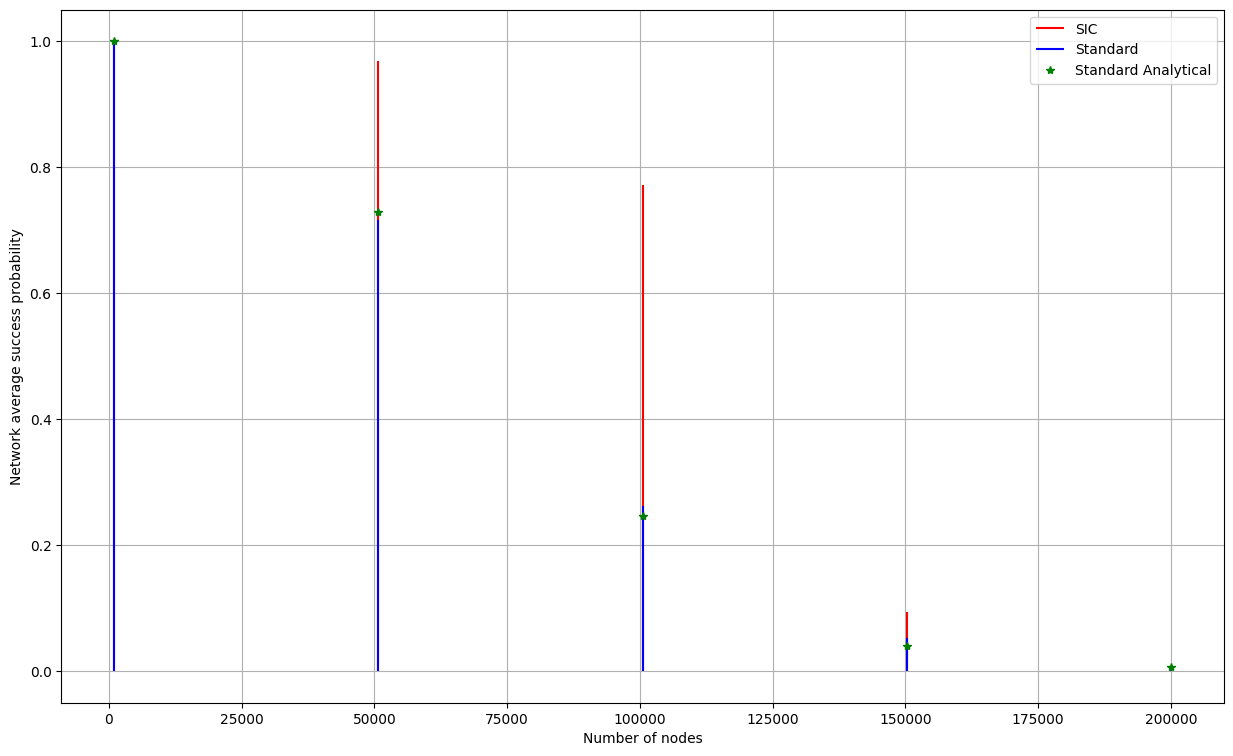

In [10]:
#Just a very simple vertical line plot
plt.figure(figsize=(15,9))
plt.vlines(nNodes*8, ymin = 0, ymax = success_sic, color='red')
plt.vlines(nNodes*8, ymin = 0, ymax = success, color='blue')
plt.plot(nNodes*8, success_analytical, '*', color='green')
plt.grid()
plt.legend(['SIC', 'Standard', 'Standard Analytical'])
plt.xlabel("Number of nodes")
plt.ylabel("Network average success probability")
plt.show()

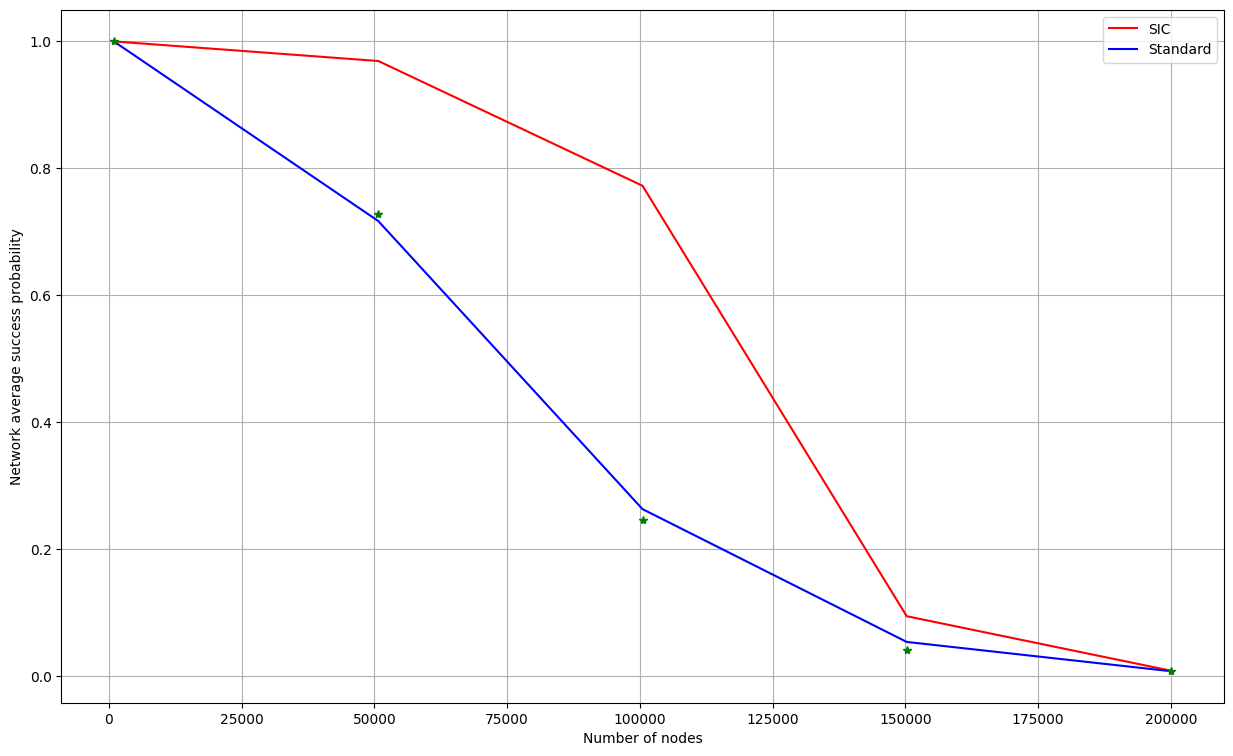

In [11]:
#Another example of plot, now making it an interpolated line between the points
plt.figure(figsize=(15,9))
plt.plot(nNodes*8, success_sic,color='red')
plt.plot(nNodes*8, success,color='blue')
plt.plot(nNodes*8, success_analytical, '*', color='green')
plt.grid()
plt.legend(['SIC', 'Standard'])
plt.xlabel("Number of nodes")
plt.ylabel("Network average success probability")
plt.show()